# A Quick and Dirty Bayesian Election Model for 2022

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialise" data-toc-modified-id="Initialise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialise</a></span><ul class="toc-item"><li><span><a href="#Import-necessary-python-modules" data-toc-modified-id="Import-necessary-python-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import necessary python modules</a></span></li><li><span><a href="#Locations" data-toc-modified-id="Locations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Locations</a></span></li><li><span><a href="#Plotting-setup" data-toc-modified-id="Plotting-setup-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting setup</a></span></li><li><span><a href="#PyMC-setup" data-toc-modified-id="PyMC-setup-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>PyMC setup</a></span></li></ul></li><li><span><a href="#Get-the-data-we-will-use-for-analysis" data-toc-modified-id="Get-the-data-we-will-use-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data we will use for analysis</a></span><ul class="toc-item"><li><span><a href="#Polling-window-before-an-election" data-toc-modified-id="Polling-window-before-an-election-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Polling window before an election</a></span></li><li><span><a href="#Voting-data" data-toc-modified-id="Voting-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Voting data</a></span></li><li><span><a href="#Seats-won-data" data-toc-modified-id="Seats-won-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Seats won data</a></span></li><li><span><a href="#Minor-seat-data" data-toc-modified-id="Minor-seat-data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Minor seat data</a></span></li><li><span><a href="#Polling-History" data-toc-modified-id="Polling-History-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Polling History</a></span></li><li><span><a href="#Current-polling-data" data-toc-modified-id="Current-polling-data-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Current polling data</a></span></li></ul></li><li><span><a href="#Bayesian-model" data-toc-modified-id="Bayesian-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bayesian model</a></span><ul class="toc-item"><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Model-constants" data-toc-modified-id="Model-constants-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model constants</a></span></li><li><span><a href="#Data-marshalling" data-toc-modified-id="Data-marshalling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Data marshalling</a></span><ul class="toc-item"><li><span><a href="#from-pre-election-polls-to-the-2pp-election-result" data-toc-modified-id="from-pre-election-polls-to-the-2pp-election-result-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>from pre-election polls to the 2pp election result</a></span></li><li><span><a href="#From-election-result-to-seats-in-Parliament" data-toc-modified-id="From-election-result-to-seats-in-Parliament-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>From election result to seats in Parliament</a></span></li><li><span><a href="#Independents-and-minor-parties" data-toc-modified-id="Independents-and-minor-parties-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Independents and minor parties</a></span></li></ul></li><li><span><a href="#The-Model" data-toc-modified-id="The-Model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>The Model</a></span><ul class="toc-item"><li><span><a href="#From-the-polls-to-an-election-result" data-toc-modified-id="From-the-polls-to-an-election-result-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>From the polls to an election result</a></span></li><li><span><a href="#From-an-election-result-to-notional-seats-in-Parliament" data-toc-modified-id="From-an-election-result-to-notional-seats-in-Parliament-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>From an election result to notional seats in Parliament</a></span></li><li><span><a href="#Identify-seats-for-independents-and-minor-parties" data-toc-modified-id="Identify-seats-for-independents-and-minor-parties-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Identify seats for independents and minor parties</a></span></li><li><span><a href="#Tabulate-the-final-results" data-toc-modified-id="Tabulate-the-final-results-3.4.4"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>Tabulate the final results</a></span></li><li><span><a href="#Bring-all-the-elements-together-into-the_model" data-toc-modified-id="Bring-all-the-elements-together-into-the_model-3.4.5"><span class="toc-item-num">3.4.5&nbsp;&nbsp;</span>Bring all the elements together into the_model</a></span></li></ul></li><li><span><a href="#Model-visualisation" data-toc-modified-id="Model-visualisation-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Model visualisation</a></span></li><li><span><a href="#Sampling,-diagnostics,-data-extraction" data-toc-modified-id="Sampling,-diagnostics,-data-extraction-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Sampling, diagnostics, data extraction</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Plot results</a></span><ul class="toc-item"><li><span><a href="#Bayesian-regressions-from-the-model" data-toc-modified-id="Bayesian-regressions-from-the-model-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>Bayesian regressions from the model</a></span><ul class="toc-item"><li><span><a href="#Polls-to-election-results" data-toc-modified-id="Polls-to-election-results-3.7.1.1"><span class="toc-item-num">3.7.1.1&nbsp;&nbsp;</span>Polls to election results</a></span></li><li><span><a href="#Bayesian-regression---from-election-result-to-notional-Coalition-seats" data-toc-modified-id="Bayesian-regression---from-election-result-to-notional-Coalition-seats-3.7.1.2"><span class="toc-item-num">3.7.1.2&nbsp;&nbsp;</span>Bayesian regression - from election result to notional Coalition seats</a></span></li><li><span><a href="#Bayesian-regression---other-party-votes-to-seats" data-toc-modified-id="Bayesian-regression---other-party-votes-to-seats-3.7.1.3"><span class="toc-item-num">3.7.1.3&nbsp;&nbsp;</span>Bayesian regression - other party votes to seats</a></span></li></ul></li><li><span><a href="#2pp-Vote-Share" data-toc-modified-id="2pp-Vote-Share-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>2pp Vote Share</a></span></li><li><span><a href="#Number-of-seats-won-by-party" data-toc-modified-id="Number-of-seats-won-by-party-3.7.3"><span class="toc-item-num">3.7.3&nbsp;&nbsp;</span>Number of seats won by party</a></span></li><li><span><a href="#Parliamentary-outcomes" data-toc-modified-id="Parliamentary-outcomes-3.7.4"><span class="toc-item-num">3.7.4&nbsp;&nbsp;</span>Parliamentary outcomes</a></span></li></ul></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Initialise

### Import necessary python modules

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pymc as pm
import arviz as az
import statsmodels.api as sm

# system imports
from io import StringIO
from pathlib import Path

# local imports
import common

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri May 20 2022 21:09:39

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

matplotlib : 3.5.2
statsmodels: 0.13.2
pymc       : 4.0.0b6
arviz      : 0.12.1
pandas     : 1.4.2
numpy      : 1.22.3

Watermark: 2.3.0



### Locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting setup

In [4]:
plt.style.use('./markgraph.mplstyle')
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER
from matplotlib.ticker import MaxNLocator

### PyMC setup

In [5]:
# Note this messes with my style sheet
az.style.use("arviz-darkgrid")

## Get the data we will use for analysis

### Polling window before an election

In [6]:
FINAL_POLLING_PERIOD = 7 # days

### Voting data

In [7]:
historic_vote_data = """
Year    Date         ALP     LP      LNP  NP      CLP  DLP  DEM     GRN     ON   Others GovtBefore GovtAfter Labor2pp
1946    28-Sep-1946  49.7    33.0    -    10.7    -    -    -       -       -    6.6    Labor      Labor     54.1
1949    10-Dec-1949  46.0    39.3    -    10.8    -    -    -       -       -    3.9    Labor      Coalition 49.0
1951    28-Apr-1951  47.7    40.5    -    9.7     -    -    -       -       -    2.1    Coalition  Coalition 49.3
1954    29-May-1954  50.1    38.5    -    8.5     -    -    -       -       -    2.9    Coalition  Coalition 50.7
1955    10-Dec-1955  44.7    39.7    -    7.9     -    5.1  -       -       -    2.6    Coalition  Coalition 45.8
1958    22-Nov-1958  42.9    37.1    -    9.3     -    9.4  -       -       -    1.3    Coalition  Coalition 45.9
1961    09-Dec-1961  48.0    33.5    -    8.5     -    8.7  -       -       -    1.4    Coalition  Coalition 50.5
1963    30-Nov-1963  45.5    37.1    -    8.9     -    7.4  -       -       -    1.0    Coalition  Coalition 47.4
1966    26-Nov-1966  40.0    40.1    -    9.8     -    7.3  -       -       -    2.7    Coalition  Coalition 43.1
1969    25-Oct-1969  47.0    34.8    -    8.6     -    6.0  -       -       -    3.7    Coalition  Coalition 50.2
1972    02-Dec-1972  49.6    32.0    -    9.4     -    5.2  -       -       -    3.7    Coalition  Labor     52.7
1974    18-May-1974  49.3    34.9    -    10.8    -    1.4  -       -       -    3.5    Labor      Labor     51.7
1975    13-Dec-1975  42.8    41.8    -    11.0    0.2  1.3  -       -       -    2.8    Labor      Coalition 44.3
1977    10-Dec-1977  39.6    38.1    -    9.8     0.2  1.4  9.4     -       -    1.4    Coalition  Coalition 45.4
1980    18-Oct-1980  45.1    37.4    -    8.6     0.2  0.3  6.6     -       -    1.7    Coalition  Coalition 49.6
1983    05-Mar-1983  49.5    34.4    -    9.0     0.2  0.2  5.0     -       -    1.7    Coalition  Labor     53.2
1984    01-Dec-1984  47.5    34.1    -    10.6    0.3  0.6  5.4     -       -    1.4    Labor      Labor     51.8
1987    11-Jul-1987  45.8    34.3    -    11.5    0.2  -    6.0     -       -    2.0    Labor      Labor     50.8
1990    24-Mar-1990  39.4    34.8    -    8.4     0.3  -    11.3    1.4     -    4.4    Labor      Labor     49.9
1993    13-Mar-1993  44.9    36.8    -    7.2     0.3  -    3.8     1.9     -    5.2    Labor      Labor     51.4
1996    02-Mar-1996  38.8    38.7    -    8.2     0.4  -    6.8     2.9     -    4.3    Labor      Coalition 46.4
1998    03-Oct-1998  40.1    33.9    -    5.3     0.3  -    5.1     2.6     8.4  4.2    Coalition  Coalition 51.0
2001    10-Nov-2001  37.8    37.1    -    5.6     0.3  -    5.4     5.0     4.3  4.4    Coalition  Coalition 49.0
2004    09-Oct-2004  37.6    40.5    -    5.9     0.3  -    1.2     7.2     1.2  6.0    Coalition  Coalition 47.3
2007    24-Nov-2007  43.4    36.3    -    5.5     0.3  -    0.7     7.8     0.3  5.8    Coalition  Labor     52.7
2010    21-Aug-2010  38.0    30.5    9.1  3.7     0.3  -    0.2     11.8    0.2  6.2    Labor      Labor     50.1
2013    07-Sep-2013  33.4    32.0    8.9  4.3     0.3  0.3  -       8.6     0.2  11.9   Labor      Coalition 46.5
2016    02-Jul-2016  34.7    28.7    8.5  4.6     0.2  -    -       10.2    1.3  11.7   Coalition  Coalition 49.6
2019    18-May-2019  33.34   27.99   8.67 4.51    0.27 -    -       10.40   3.08 11.74  Coalition  Coalition 48.5
"""
# https://en.wikipedia.org/wiki/Two-party-preferred_vote
# https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp1617/FederalElectionResults

historic_vote_data = pd.read_csv(StringIO(historic_vote_data), 
                                 header=0, index_col=0, 
                                 skipinitialspace=True, sep=' ', 
                                 na_values='-',
                                 parse_dates=['Date'])
historic_vote_data['Coalition2pp'] = 100.0 - historic_vote_data['Labor2pp']
historic_vote_data['CoalitionMargin'] = historic_vote_data.Coalition2pp - historic_vote_data.Labor2pp
historic_vote_data


,Date,ALP,LP,LNP,NP,CLP,DLP,DEM,GRN,ON,Others,GovtBefore,GovtAfter,Labor2pp,Coalition2pp,CoalitionMargin
Year,,,,,,,,,,,,,,,,
1946,1946-09-28,49.70,33.00,NaN,10.70,NaN,NaN,NaN,NaN,NaN,6.60,Labor,Labor,54.1,45.9,-8.2
1949,1949-12-10,46.00,39.30,NaN,10.80,NaN,NaN,NaN,NaN,NaN,3.90,Labor,Coalition,49.0,51.0,2.0
1951,1951-04-28,47.70,40.50,NaN,9.70,NaN,NaN,NaN,NaN,NaN,2.10,Coalition,Coalition,49.3,50.7,1.4
1954,1954-05-29,50.10,38.50,NaN,8.50,NaN,NaN,NaN,NaN,NaN,2.90,Coalition,Coalition,50.7,49.3,-1.4
1955,1955-12-10,44.70,39.70,NaN,7.90,NaN,5.1,NaN,NaN,NaN,2.60,Coalition,Coalition,45.8,54.2,8.4
1958,1958-11-22,42.90,37.10,NaN,9.30,NaN,9.4,NaN,NaN,NaN,1.30,Coalition,Coalition,45.9,54.1,8.2
1961,1961-12-09,48.00,33.50,NaN,8.50,NaN,8.7,NaN,NaN,NaN,1.40,Coalition,Coalition,50.5,49.5,-1.0
1963,1963-11-30,45.50,37.10,NaN,8.90,NaN,7.4,NaN,NaN,NaN,1.00,Coalition,Coalition,47.4,52.6,5.2
1966,1966-11-26,40.00,40.10,NaN,9.80,NaN,7.3,NaN,NaN,NaN,2.70,Coalition,Coalition,43.1,56.9,13.8


In [8]:
OTHERS = ['DLP', 'DEM', 'GRN', 'ON', 'Others']
other_vote_summary = historic_vote_data[OTHERS].fillna(0).sum(axis=1)
other_vote_summary

Year
1946     6.60
1949     3.90
1951     2.10
1954     2.90
1955     7.70
1958    10.70
1961    10.10
1963     8.40
1966    10.00
1969     9.70
1972     8.90
1974     4.90
1975     4.10
1977    12.20
1980     8.60
1983     6.90
1984     7.40
1987     8.00
1990    17.10
1993    10.90
1996    14.00
1998    20.30
2001    19.10
2004    15.60
2007    14.60
2010    18.40
2013    21.00
2016    23.20
2019    25.22
dtype: float64

### Seats won data

In [9]:
seats_won = pd.read_csv(f'{PRIVATE_DATA_DIR}Seat History.csv',
                        header=[0,1], index_col=0, 
                       )
seats_won = seats_won['Seats']
seats_won.index = [pd.Timestamp(x) for x in seats_won.index]
seats_won

,ALP,L+NP,Oth.,Total
1919-12-13,25.0,38.0,2.0,75.0
1922-12-16,29.0,40.0,6.0,75.0
1925-11-14,23.0,50.0,2.0,75.0
1928-11-17,31.0,42.0,2.0,75.0
1929-10-12,46.0,24.0,5.0,75.0
1931-12-19,14.0,50.0,11.0,75.0
1934-09-15,18.0,42.0,14.0,74.0
1937-10-23,29.0,43.0,2.0,74.0
1940-09-21,32.0,36.0,6.0,74.0
1943-08-21,49.0,19.0,6.0,74.0


### Minor seat data

In [10]:
minors = """Year; Minor seats; Coalition minor; Notes
2019; 6; 4;    4 in Coalition seats: Katter, Haines, Steggal, Sharkie - 2 in Labor Seats: Wilkie, Bandt
2016; 5; 3;    3 in Coalition seats: Katter, McGowan, Sharkie - 2 in Labor Seats: Wilkie, Bandt
2013; 5; 3;    3 in Coalition seats: Palmer, McGowan, Katter - 2 in Labor seats: Bandt, Wilkie
2010; 6; 4;    4 in Coalition seats: Oakshott, Windsor, Katter, Crook - 2 in Labor seats: Bandt, Wilkie
2007; 2; 2;    2 in Coalition seats: Windsor, Katter
2004; 3; 3;    3 in Coalition seats: Andren, Windsor, Katter
2001; 3; 3;    3 in Coalition Seats: Andren, Windsor, Katter
1998; 1; 1;    1 in a Coalition seat: Andren
1996; 5; 4;    4 in Coalition seats: Hanson, Andren, Rocher, Filing, - 1 in a Labor seat: Campbell
1993; 2; 1;    1 in Coalition a seat: Mack - 1 in a Labor seat: Cleary
1990; 1; 1;    1 in a Coalition seat Mack
1987; 0; 0;
1984; 0; 0;
1983; 0; 0; """


minors = pd.read_csv(StringIO(minors), header=0, index_col=0, 
                    skipinitialspace=True, sep=';')
minors['Coalition Proportion'] = minors['Coalition minor'] / minors['Minor seats']
minors['Date'] = historic_vote_data['Date']
minors

,Minor seats,Coalition minor,Notes,Coalition Proportion,Date
Year,,,,,
2019,6,4,"4 in Coalition seats: Katter, Haines, Steggal,...",0.666667,2019-05-18
2016,5,3,"3 in Coalition seats: Katter, McGowan, Sharkie...",0.600000,2016-07-02
2013,5,3,"3 in Coalition seats: Palmer, McGowan, Katter ...",0.600000,2013-09-07
2010,6,4,"4 in Coalition seats: Oakshott, Windsor, Katte...",0.666667,2010-08-21
2007,2,2,"2 in Coalition seats: Windsor, Katter",1.000000,2007-11-24
2004,3,3,"3 in Coalition seats: Andren, Windsor, Katter",1.000000,2004-10-09
2001,3,3,"3 in Coalition Seats: Andren, Windsor, Katter",1.000000,2001-11-10
1998,1,1,1 in a Coalition seat: Andren,1.000000,1998-10-03
1996,5,4,"4 in Coalition seats: Hanson, Andren, Rocher, ...",0.800000,1996-03-02


In [11]:
adjusted_seats = seats_won.copy()
adjusted_seats.index = adjusted_seats.index.year
adjusted_seats = adjusted_seats.loc[minors.index]
adjusted_seats['Coalition adjusted'] = adjusted_seats['L+NP'] + minors['Coalition minor']
adjusted_seats['Labor adjusted'] = adjusted_seats['ALP'] + minors['Minor seats'] - minors['Coalition minor']
adjusted_seats['Coalition proportion'] = adjusted_seats['Coalition adjusted'] / adjusted_seats.Total
adjusted_seats['Labor proportion'] = adjusted_seats['Labor adjusted'] / adjusted_seats.Total
adjusted_seats['CoalitionMargin'] = adjusted_seats['Coalition proportion'] - adjusted_seats['Labor proportion']

assert (adjusted_seats['Labor adjusted'] + adjusted_seats['Coalition adjusted'] == adjusted_seats.Total).all()


### Polling History

In [12]:
# Historical polling data from Ethan at https://armariuminterreta.com/
IGNORE_BEFORE = pd.Timestamp('1983-01-01')

historical = pd.read_excel(f'{PRIVATE_DATA_DIR}Australian Federal Polling Database.xlsx',)
historical = historical[historical.StartDate >= IGNORE_BEFORE]
len(historical)

2853

In [13]:
historical.columns

Index(['StartDate', 'EndDate', 'ElectionYear', 'FieldDays', 'DaysToElection',
       'DaysFromLastElection', 'Incumbent', 'Pollster', 'SamplingMethod',
       'SampleSize', 'ALP', 'LNC', 'Liberals', 'Nationals', 'DLP', 'Democrats',
       'Greens', 'PHON', 'Others', 'Undecided', 'Published2pp', 'RespAlloc2pp',
       'Raw2pp', 'Est2pp', '2pp', 'RoundedEst2pp', 'PrimMargin', 'Result2pp',
       'DevALP', 'DevLNC', 'DevLib', 'DevNat', 'DevDLP', 'DevDem', 'DevGrn',
       'DevPHON', 'DevOth', 'DevPub2pp', 'DevEst2pp', 'Dev2pp',
       'DevPastInc2pp', 'DevInc2pp', 'AbsDevALP', 'AbsDevLNC', 'AbsDevLib',
       'AbsDevNat', 'AbsDevDLP', 'AbsDevDem', 'AbsDevGrn', 'AbsDevPHON',
       'AbsDevOth', 'AbsDevPub2pp', 'AbsDevEst2pp', 'AbsDev2pp'],
      dtype='object')

In [14]:
# polling summary
COALITION_2PP = 'Est2pp'
MAJORS = ['ALP', 'LNC', 'Liberals', 'Nationals', ]
MINORS = ['DLP', 'Democrats', 'Greens', 'PHON', 'Others', ]
PRIMARY = MAJORS + MINORS

summary_tpp = {}
summary_other = {}
for date in historic_vote_data['Date']:
    end = pd.Timestamp(date)
    begin = end - pd.Timedelta(days=FINAL_POLLING_PERIOD)
    data = historical[(historical['StartDate'] >= begin) & (historical['EndDate'] <= end)].fillna(0)
    if len(data) < 1:
        continue
        
    # tpp poll estimate
    summary_tpp[date] = data[COALITION_2PP].mean()
    
    # "Other" poll estimate
    summary_other[date] =( data[MINORS].sum(axis=1) / data[PRIMARY].sum(axis=1) * 100).mean()
    
tpp_poll_summary = pd.Series(summary_tpp)
tpp_poll_summary

1983-03-05    45.575000
1984-12-01    44.300000
1987-07-11    46.500000
1990-03-24    48.900000
1993-03-13    50.675000
1996-03-02    51.014286
1998-10-03    49.333333
2001-11-10    51.000000
2004-10-09    52.150000
2007-11-24    46.266667
2010-08-21    48.287500
2013-09-07    53.211111
2016-07-02    50.440000
2019-05-18    48.300000
dtype: float64

In [15]:
# Other polling summary
other_poll_summary = pd.Series(summary_other)
other_poll_summary

1983-03-05     6.625000
1984-12-01     9.000000
1987-07-11     7.018519
1990-03-24    14.803171
1993-03-13     9.935345
1996-03-02    14.857143
1998-10-03    17.057239
2001-11-10    12.967709
2004-10-09    12.348024
2007-11-24    10.368847
2010-08-21    15.594155
2013-09-07    21.334604
2016-07-02    23.412081
2019-05-18    25.666667
dtype: float64

### Current polling data

In [16]:
current_polls = f'{PUBLIC_DATA_DIR}primary_vote.csv' 
common.check_file_current(current_polls, 
    'Make sure you run the data capture notebook first')

tpp = pd.read_csv(current_polls, parse_dates=['Mean Date'], index_col=0)
final = tpp['Mean Date'].max()
start = final - pd.Timedelta(days=FINAL_POLLING_PERIOD)
retain_polls = (tpp['Mean Date'] >= start) & (tpp['Mean Date'] <= final)
current_tpp_poll = tpp.loc[retain_polls,'Calculated 2pp L/NP'].mean()
current_tpp_poll # for the Coalition

47.122228901922455

In [17]:
# List retained polls, from which the mean poll was calculated.
cols = ['Date', 'Mean Date', 'Brand', 'Sample size', 
        'Calculated 2pp L/NP', 'Calculated 2pp ALP']
tpp.loc[retain_polls, cols]

,Date,Mean Date,Brand,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
152,10–13 May 2022,2022-05-11,Newspoll-YouGov,1532.0,46.239000,53.761000
153,9–15 May 2022,2022-05-12,Roy Morgan,1366.0,46.441000,53.559000
154,12–17 May 2022,2022-05-14,Resolve Strategic,2049.0,48.387879,51.612121
155,14–16 May 2022,2022-05-15,Essential,1600.0,48.478495,51.521505
156,15–18 May 2022,2022-05-16,Ipsos,1996.0,46.436000,53.564000
157,13–19 May 2022,2022-05-16,Newspoll-YouGov,2188.0,46.751000,53.249000


In [18]:
OTHERS = ['Primary vote GRN', 'Primary vote OTH', 
          'Primary vote UAP', 'Primary vote ONP', ]
current_primary_others_poll = tpp.loc[
    (tpp['Mean Date'] >= start) & (tpp['Mean Date'] <= final),
    OTHERS].sum(axis=1, skipna=True).mean()
current_primary_others_poll

29.16655805365483

## Bayesian model

### Supporting functions

In [19]:
def annotate_dots(ax, x, y, s):
    # annotate scatter plot dots
    for x_, y_, s_ in zip(x, y, [f'{t}' for t in s]):
        ax.text(x_, y_, s_, ha='left', va='bottom')

In [20]:
def regression_line(ax, x, y):
    # place a regression line of the plot
    m, b = np.polyfit(x, y, 1)
    regression_text = f'y = {m:0.3f}x {"+ " if b >=0 else ""}{b:0.3f}'
    x_r = np.array(sorted(x))
    y_r = (m * x_r) + b
    ax.plot(x_r, y_r, lw=1, c="#dd0000", label=regression_text)
    return regression_text, m, b

In [21]:
def y_eq_x_line(ax):
    # place an y=x line on the plot ...
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]), 
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    ax.plot(lims, lims, lw=1, ls='--', c='darkorchid', label='y = x')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

In [22]:
def get_var_as_series(inferencedata, variable_name):
    """Return a series - index are draws"""
    return pd.Series(
        inferencedata
        .posterior
        .stack(draws=("chain", "draw"))[variable_name]
        .values
    )

### Model constants

In [23]:
SEATS_IN_HOUSE = 151
CUT_OFF = 1983

# These next constants are for NUTS related data transformations
# (or offsets) so that we are mostly modelling in the -2 to 2 range
FIFTY = 50.0 # per cent - offset for centre adjustment
TEN = 10.0
FIFTEEN = 15.0
THREE = 3.0

### Data marshalling

#### from pre-election polls to the 2pp election result

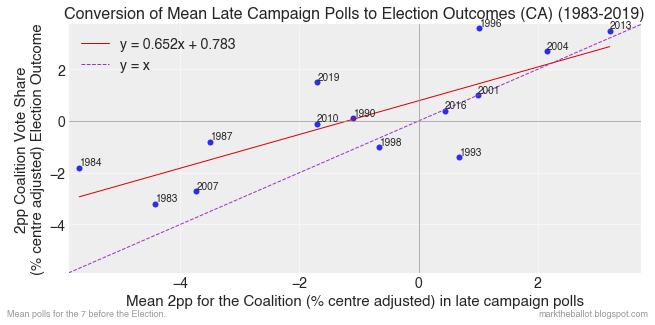

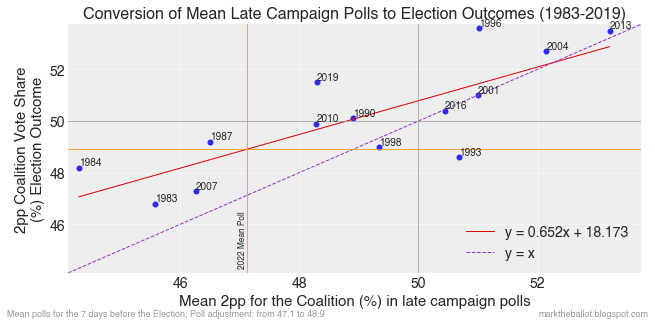

In [24]:
# polls and votes in whole percentage points - centre adjusted
# we sort to ensure our lists are in the same order
# We use a centre-adjusted transformation to make the NUTS sampler work better

polls = tpp_poll_summary.sort_index().values - FIFTY
votes = (
    historic_vote_data.loc[historic_vote_data.index >= CUT_OFF, 'Coalition2pp']
    .sort_index()
    .values - FIFTY
)
assert len(polls) == len(votes) # to be sure ...

fig, ax = common.initiate_plot()
ax.scatter(polls, votes)
annotate_dots(ax, polls, votes, tpp_poll_summary.sort_index().index.year)
regression_line(ax, polls, votes, )
y_eq_x_line(ax)
ax.axvline(0, lw=0.75, c='#999999')
ax.axhline(0, lw=0.75, c='#999999')
ax.legend(loc='best')
common.plot_finalise(
    ax,
    title='Conversion of Mean Late Campaign Polls to Election Outcomes (CA) '
    f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
    xlabel='Mean 2pp for the Coalition (% centre adjusted) in late campaign polls',
    ylabel='2pp Coalition Vote Share\n(% centre adjusted) Election Outcome',
    lfooter=f'Mean polls for the {FINAL_POLLING_PERIOD} before the Election.'
)

# And the same chart withou cenre-adjustment
x, y = polls + FIFTY, votes + FIFTY
fig, ax = common.initiate_plot()
ax.scatter(x, y)
annotate_dots(ax, x, y, tpp_poll_summary.sort_index().index.year)
(_, m, b) = regression_line(ax, x, y, )
y_eq_x_line(ax)
ax.axvline(FIFTY, lw=0.75, c='#999999')
ax.axhline(FIFTY, lw=0.75, c='#999999')

# How the current mean is treated ...
ax.axvline(current_tpp_poll, lw=0.75, c='darkorange')
ylim = ax.get_ylim()
adj = (ylim[1] - ylim[0]) * 0.02
ax.text(current_tpp_poll, ylim[0]+adj, '2022 Mean Poll',
        ha='right', va='bottom', rotation=90, fontsize='small')
projected = m * current_tpp_poll + b
ax.axhline(projected, lw=0.75, c='darkorange')

ax.legend(loc='best')
common.plot_finalise(
    ax,
    title='Conversion of Mean Late Campaign Polls to Election Outcomes '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
    xlabel='Mean 2pp for the Coalition (%) in late campaign polls',
    ylabel='2pp Coalition Vote Share\n(%) Election Outcome',
    lfooter=f'Mean polls for the {FINAL_POLLING_PERIOD} days before the Election; '
            f'Poll adjustment: from {current_tpp_poll:0.1f} to {projected:0.1f}',
)

__Note:__ The solid red regression line suggests the polls perform poorer when Labor is doing well in the polls, 
but they are more accurate when the Coalition is doing well. This is highlighted by the dashed y=x line. 

#### From election result to seats in Parliament

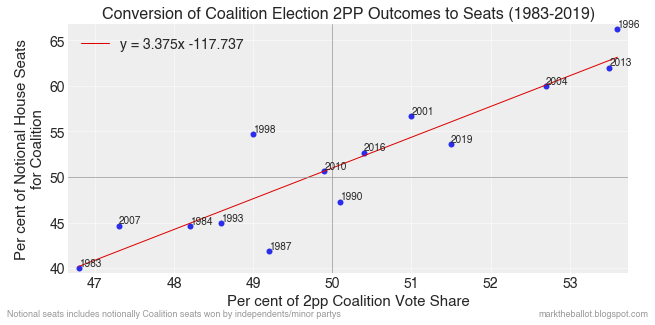

In [25]:
# data - adjust for NUTS
c_seats = (
    (adjusted_seats['Coalition proportion']
    .sort_index()
    .values * 100) 
)
c_votes = (
    historic_vote_data.loc[adjusted_seats.index, 'Coalition2pp'] 
    .sort_index()
    .values
)
assert len(c_seats) == len(c_votes)

x, y = c_votes , c_seats
fig, ax = common.initiate_plot()
ax.scatter(x, y)
annotate_dots(ax, x, y, adjusted_seats.sort_index().index)
regression_line(ax, x, y, )
ax.axvline(FIFTY, lw=0.75, c='#999999')
ax.axhline(FIFTY, lw=0.75, c='#999999')

ax.legend(loc='upper left')
common.plot_finalise(ax,
    title='Conversion of Coalition Election 2PP Outcomes to Seats '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Per cent of 2pp Coalition Vote Share',
                     ylabel='Per cent of Notional House Seats\nfor Coalition',
                     lfooter='Notional seats includes notionally Coalition seats won '
                            'by independents/minor partys')


#### Independents and minor parties

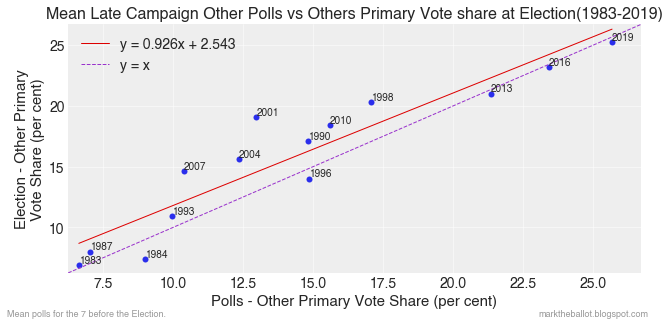

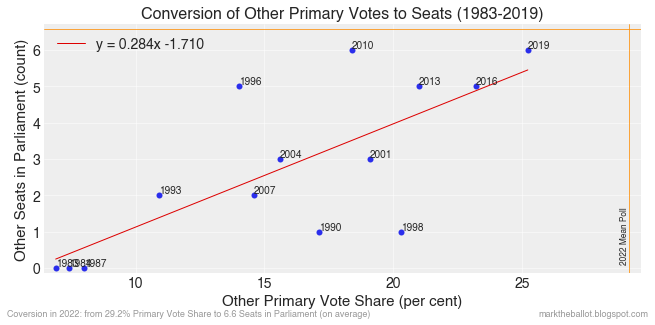

In [26]:
OTHER_CUT_OFF = pd.Timestamp('1983-01-01') 
other_polls = (
    other_poll_summary[other_poll_summary.index >= OTHER_CUT_OFF]
    .sort_index()
    .values
)
other_seats = (
    minors.loc[minors.index >= OTHER_CUT_OFF.year, 'Minor seats']
    .astype(float)
    .sort_index()
    .values
)
other_votes = (
    other_vote_summary[other_vote_summary.index >= OTHER_CUT_OFF.year]
    .sort_index()
    .values
)
# NUTS Adjustment follows ...
assert len(other_polls) == len(other_seats) == len(other_votes)

fig, ax = common.initiate_plot()
ax.scatter(other_polls, other_votes)
annotate_dots(ax, other_polls, other_votes, adjusted_seats.sort_index().index)
regression_line(ax, other_polls, other_votes, )
y_eq_x_line(ax)
ax.legend(loc='upper left')
common.plot_finalise(ax,
    title='Mean Late Campaign Other Polls vs Others Primary Vote share at Election'
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Polls - Other Primary Vote Share (per cent)',
                     ylabel='Election - Other Primary\nVote Share (per cent)',
                     lfooter=f'Mean polls for the {FINAL_POLLING_PERIOD} '
                             'before the Election.')

fig, ax = common.initiate_plot()
ax.scatter(other_votes, other_seats)
annotate_dots(ax, other_votes, other_seats, adjusted_seats.sort_index().index)
_, m, b = regression_line(ax, other_votes, other_seats, )

# The current poll average
ax.axvline(current_primary_others_poll, lw=0.75, c='darkorange')
ax.text(current_primary_others_poll, 0.1, '2022 Mean Poll',
        ha='right', va='bottom', rotation=90, fontsize='small')
projected = m * current_primary_others_poll + b
ax.axhline(projected, lw=0.75, c='darkorange')

ax.legend(loc='upper left')
common.plot_finalise(
    ax,
    title='Conversion of Other Primary Votes to Seats '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
    xlabel='Other Primary Vote Share (per cent)',
    ylabel='Other Seats in Parliament (count)',
    lfooter=f'Coversion in 2022: from {current_primary_others_poll:0.1f}% Primary Vote '
            f'Share to {projected:0.1f} Seats in Parliament (on average)',
)

Observation: for the last three elections, the polls did a pretty good job at forecasting the other vote share.

Nonetheless, the primary vote share is only a weak indicator of the number of "other: seats that are won.

### The Model

___Note___: the model is broken into four parts, so each part can be tested individually. However, they are intended to be run as a joint model. 

#### From the polls to an election result

In [27]:
def from_polls_to_election():
    
    pe_x_coeff = pm.Normal('pe_x_coeff', 0, sigma=10)
    pe_intercept = pm.Normal('pe_intercept', 0, sigma=10)
    pe_nu = pm.Gamma('pe_nu', alpha=5, beta=0.1) 
    pe_sigma = pm.Exponential('pe_sigma', lam=2.0)
    historic_polls_to_votes = pm.StudentT("historic_polls_to_votes", 
                                nu=pe_nu, # For StudentT
                                mu=pe_intercept + polls * pe_x_coeff, 
                                sigma=pe_sigma,
                                observed=votes,)
    # - projected election 2pp result
    vote_2pp_C_predicted_ca = pm.StudentT("vote_2pp_C_predicted_ca", 
                                nu=pe_nu, # For StudentT
                                mu=(current_tpp_poll - FIFTY) * pe_x_coeff + pe_intercept,
                                sigma=pe_sigma,)
    vote_2pp_C_predicted = pm.Deterministic('vote_2pp_C_predicted',
                                          FIFTY + vote_2pp_C_predicted_ca)
    vote_2pp_L_predicted = pm.Deterministic('vote_2pp_L_predicted',
                                          100.0 - vote_2pp_C_predicted)

    return vote_2pp_C_predicted

#### From an election result to notional seats in Parliament

In [28]:
def from_election_to_seats(vote_2pp_C_predicted):

    es_slope = pm.Normal('es_slope', mu=1, sigma=10)
    es_intercept = pm.Normal('es_intercept', mu=0, sigma=10)
    es_error = pm.Exponential('es_error', lam=2.0)
    es_nu = pm.Gamma('es_nu', alpha=5, beta=0.1) 
    historic_votes_to_seats = pm.StudentT('historic_votes_to_seats',
                                          nu=es_nu,
                                          mu=(c_votes-FIFTY)*es_slope+es_intercept,
                                          sigma=es_error,
                                          observed=(c_seats-FIFTY),)

    seats_C_pcent_notion_project_centred = pm.StudentT('seats_C_pcent_notion_project_centred',
                                          nu=es_nu,
                                          mu=(vote_2pp_C_predicted-FIFTY)
                                             *es_slope+es_intercept, 
                                          sigma=es_error,)
     
    seats_C_count_notional_projected = pm.Deterministic('seats_C_count_notional_projected',
                                          SEATS_IN_HOUSE 
                                          * ((seats_C_pcent_notion_project_centred+FIFTY) 
                                             / 100.0)
                                       )
    seats_L_count_notional_projected = pm.Deterministic('seats_L_count_notional_projected',
                                          SEATS_IN_HOUSE 
                                          - seats_C_count_notional_projected)

    return seats_C_count_notional_projected

#### Identify seats for independents and minor parties

In [29]:
def seats_for_minor_parties():

    op_slope = pm.Normal('op_slope', mu=0, sigma=1) 
    op_intercept = pm.Normal('op_intercept', mu=0, sigma=1)
    op_error = pm.Exponential('op_error', lam=0.5) # less constrained 
    op_nu = 5 # pm.Gamma('op_nu', 5, beta=1) # Note this model estimates a very low 
                                             # nu, which is just way too noisy.
    
    historic_others_votes_to_seats = pm.StudentT('historic_others_votes_to_seats',
                                          nu=op_nu,
                                          mu=(other_votes-THREE)*op_slope+op_intercept,
                                          sigma=op_error,
                                          observed=(other_seats-FIFTEEN)/TEN,)
    # predict the number of the other seats 
    seats_other_count_regression = pm.StudentT('seats_other_count_regression', 
                                      nu=op_nu,
                                      mu=(current_primary_others_poll-THREE)
                                         *op_slope+op_intercept,
                                      sigma=op_error,)
    
    # --- augment the independet count for 2022 - ad hoc change for teal independents
    #ad_hoc_2022_independent_adjust = pm.Gamma('ad_hoc_2022_independent_adjust',
    #                                              alpha=3, beta=2)
    #seats_other_count_unadjusted = pm.Deterministic('seats_other_count_unadjusted', 
    #                                     seats_other_count_regression*TEN+FIFTEEN)
    #seats_other_count = pm.Deterministic('seats_other_count', 
    #                                     seats_other_count_unadjusted
    #                                     +ad_hoc_2022_independent_adjust)

    seats_other_count = pm.Deterministic('seats_other_count', 
                                         seats_other_count_regression*TEN+FIFTEEN)
    
    return seats_other_count

#### Tabulate the final results

In [30]:
def final_tabulations(seats_C_count_notional_projected, 
                      seats_other_count):
    
    coalition_proportion_of_other = pm.Uniform('coalition_proportion_of_other', 
                                        lower=0.65, upper=0.8)
    coalition_lost_to_other = pm.Deterministic('coalition_lost_to_other', 
                                        coalition_proportion_of_other 
                                        * seats_other_count)
    final_coalition_seats = pm.Deterministic('final_coalition_seats',
                                        seats_C_count_notional_projected 
                                        - coalition_lost_to_other)
    final_labor_seats = pm.Deterministic('final_labor_seats',
                                         SEATS_IN_HOUSE - final_coalition_seats 
                                        - seats_other_count)    

#### Bring all the elements together into the_model

In [31]:
with pm.Model() as the_model:
    vote_2pp_C_predicted = from_polls_to_election()
    seats_C_count_notional_projected = from_election_to_seats(vote_2pp_C_predicted)
    seats_other_count = seats_for_minor_parties()
    final_tabulations(seats_C_count_notional_projected, seats_other_count)

### Model visualisation

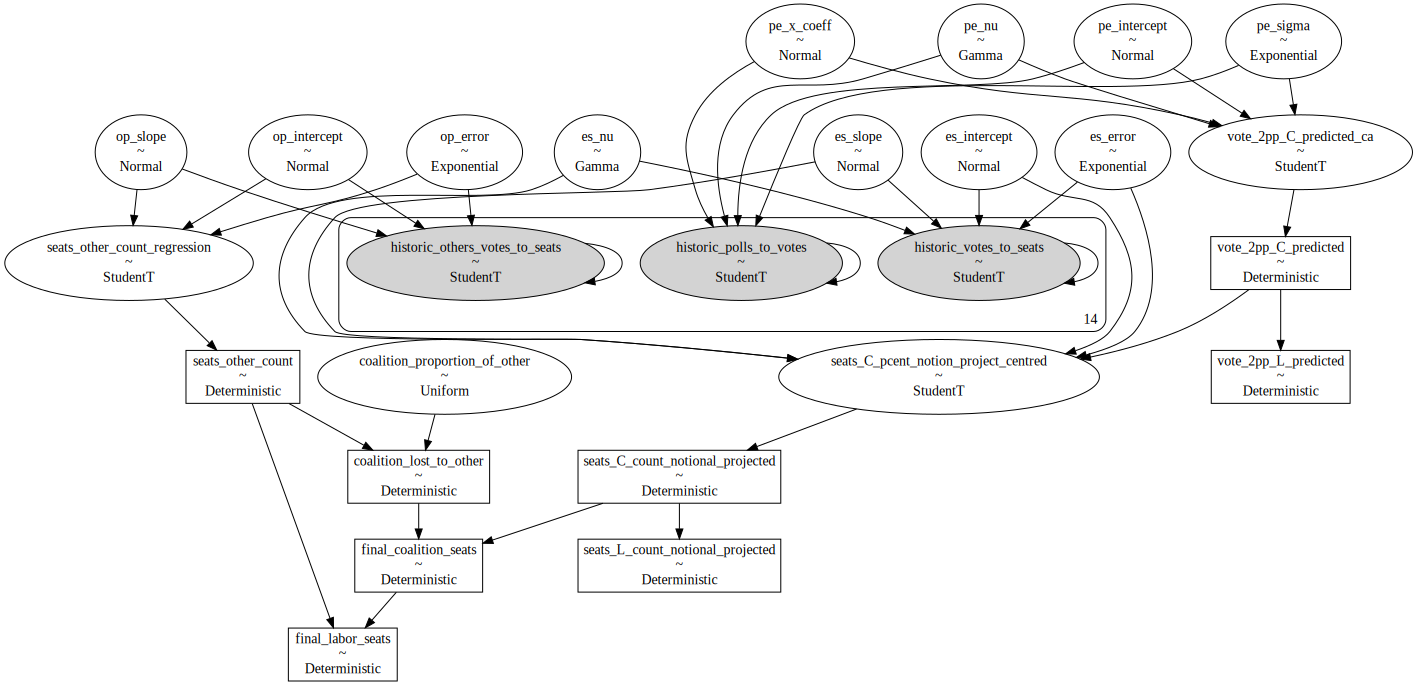

In [32]:
gv = pm.model_to_graphviz(the_model)
gv.render(format='png', filename='model-graphviz')
display(gv)

### Sampling, diagnostics, data extraction

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [pe_x_coeff, pe_intercept, pe_nu, pe_sigma, vote_2pp_C_predicted_ca, es_slope, es_intercept, es_error, es_nu, seats_C_pcent_notion_project_centred, op_slope, op_intercept, op_error, seats_other_count_regression, coalition_proportion_of_other]


Sampling 10 chains for 20_000 tune and 50_000 draw iterations (200_000 + 500_000 draws total) took 185 seconds.
The acceptance probability does not match the target. It is 0.7078, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.642, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pe_x_coeff,0.654,0.144,0.385,0.932,0.000,0.000,273043.0,238018.0,1.0
pe_intercept,0.787,0.393,0.049,1.538,0.001,0.001,274590.0,252742.0,1.0
vote_2pp_C_predicted_ca,-1.096,1.443,-3.784,1.686,0.003,0.002,224473.0,214590.0,1.0
es_slope,3.377,0.380,2.655,4.092,0.001,0.001,288472.0,239595.0,1.0
es_intercept,0.965,0.800,-0.532,2.505,0.001,0.001,292619.0,238114.0,1.0
seats_C_pcent_notion_project_centred,-2.734,5.810,-13.530,8.436,0.012,0.010,227797.0,222741.0,1.0
op_slope,0.029,0.007,0.014,0.043,0.000,0.000,250518.0,236352.0,1.0
op_intercept,-1.587,0.103,-1.777,-1.386,0.000,0.000,257712.0,240127.0,1.0
seats_other_count_regression,-0.835,0.228,-1.269,-0.414,0.000,0.000,368423.0,282604.0,1.0
pe_nu,49.856,22.331,12.415,90.995,0.038,0.027,315560.0,233037.0,1.0


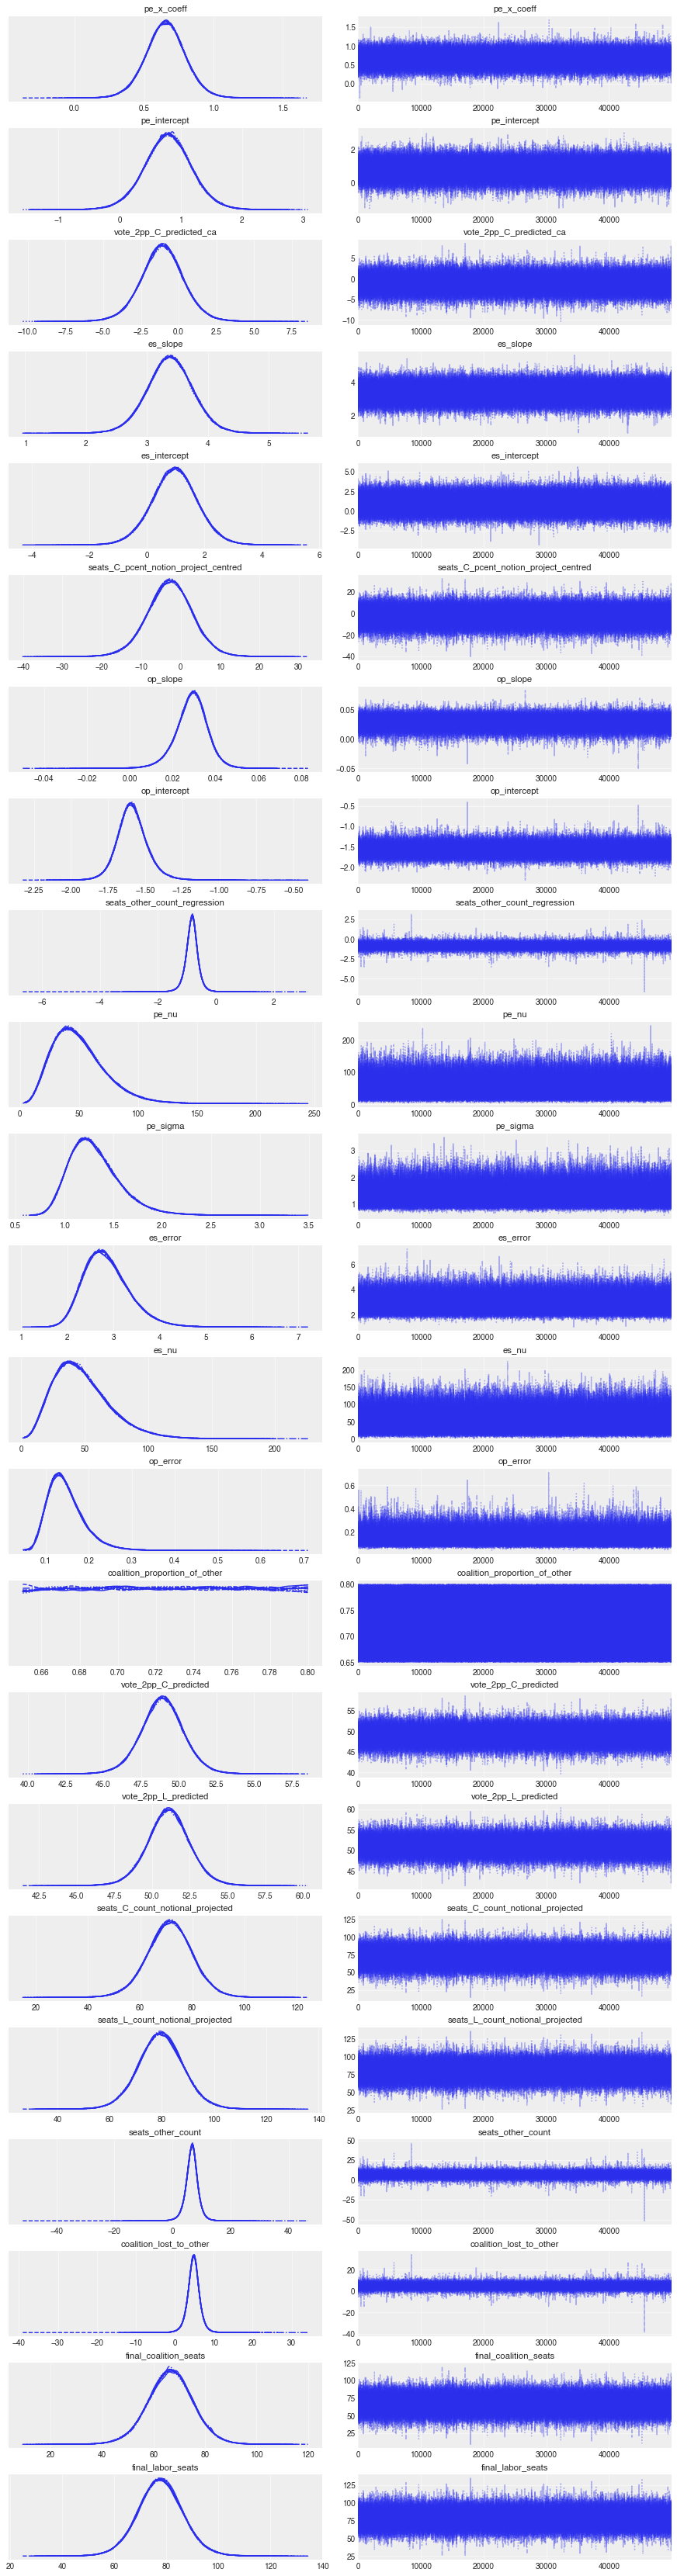

In [33]:
CHAINS = 10 # take advantage of my multi-core machine
SAMPLES_PER_CHAIN = 50_000
TUNE_PER_CHAIN = 20_000

with the_model:
    # --- sampling
    trace = pm.sample(return_inferencedata=True, 
                      draws=SAMPLES_PER_CHAIN, tune=TUNE_PER_CHAIN, 
                      chains=CHAINS, cores=CHAINS, )
    
    # --- diagnostics
    summary = az.summary(trace) 
    az.rcParams["plot.max_subplots"] = 100
    az.plot_trace(trace)
    
summary

### Plot results

#### Bayesian regressions from the model

These are a little tricky because we need to reverse the centreing and other adjustments we did for NUTS.

These plots provide a useful cross check against the simple Gaussian regressions we did in the data marshalling phase above. 

In [34]:
quants = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975] # 95% 80% 50% median
ranges = {
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}

def quantise(x_data, m, b):
    xx = np.linspace(x_data.min(), x_data.max())
    results = {}
    for x in xx:
        y = m * x + b
        results[x] = y.quantile(quants).T
    
    return pd.DataFrame(results).T, m.mean(), b.mean()

def plot_regress_quants(quants, mq, bq):
    fig, ax = common.initiate_plot()
    alpha = 0.1
    
    for label, (low, high) in ranges.items():
        ax.fill_between(quants.index, quants[low], quants[high], alpha=alpha,
                        color='darkgreen', label = label)
        alpha = alpha + 0.1
    ax.plot(quants.index, quants[0.5], lw=1.0, color='darkgreen',
            label=f'y = {mq:0.3f}x {"+" if bq >= 0 else ""} {bq:0.3f}')
        
    return ax

##### Polls to election results

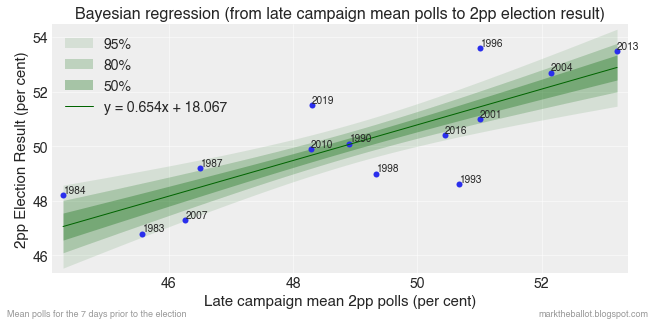

In [35]:
pe_x_coeff = get_var_as_series(trace, 'pe_x_coeff')
pe_intercept = get_var_as_series(trace, 'pe_intercept')
pe_intercept_ = -FIFTY*pe_x_coeff + pe_intercept + FIFTY # corrected y intercept

y_quants, mq, bq = quantise(polls+FIFTY, pe_x_coeff, pe_intercept_)
ax = plot_regress_quants(y_quants, mq, bq)
x, y = polls + FIFTY, votes + FIFTY
ax.scatter(x, y)
annotate_dots(ax, x, y, tpp_poll_summary.sort_index().index.year)
ax.legend(loc='best')

common.plot_finalise(
    ax, 
    title=f'Bayesian regression (from late campaign mean polls to 2pp election result)', 
    xlabel='Late campaign mean 2pp polls (per cent)',
    ylabel='2pp Election Result (per cent)',
    lfooter=f'Mean polls for the {FINAL_POLLING_PERIOD} days prior to the election'
)


##### Bayesian regression - from election result to notional Coalition seats

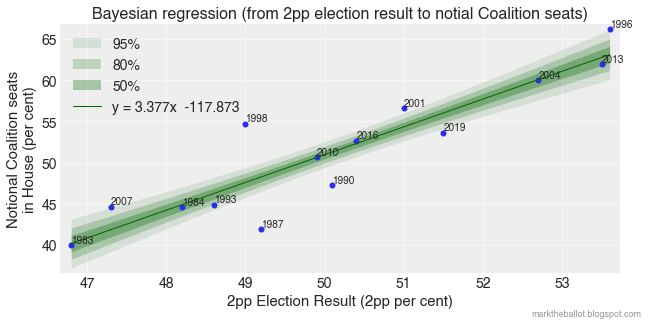

In [36]:
es_slope = get_var_as_series(trace, 'es_slope')
es_intercept = get_var_as_series(trace, 'es_intercept')
es_intercept_ = -FIFTY*es_slope + es_intercept + FIFTY # corrected y intercept

y_quants, mq, bq = quantise(c_votes, es_slope, es_intercept_)
ax = plot_regress_quants(y_quants, mq, bq)
x, y = c_votes, c_seats
ax.scatter(x, y)
annotate_dots(ax, x, y, adjusted_seats.sort_index().index)
ax.legend(loc='best')

common.plot_finalise(
    ax, 
    title=f'Bayesian regression (from 2pp election result to notial Coalition seats)', 
    xlabel='2pp Election Result (2pp per cent)',
    ylabel='Notional Coalition seats\nin House (per cent)',
)

##### Bayesian regression - other party votes to seats

In [37]:
# Get samples and reverse the NUTS transformations
op_slope = get_var_as_series(trace, 'op_slope')
op_slope_ = TEN * op_slope
op_intercept = get_var_as_series(trace, 'op_intercept')
op_intercept_ = -THREE*TEN*op_slope + TEN*op_intercept + FIFTEEN
op_slope_.mean(), op_intercept_.mean()

(0.2875085848852894, -1.7304988379322905)

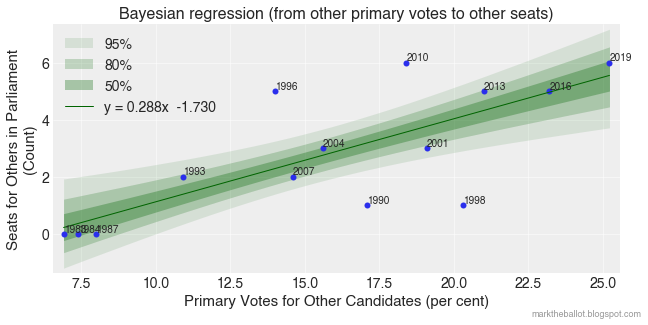

In [38]:
y_quants, mq, bq = quantise(other_votes, op_slope_, op_intercept_)
ax = plot_regress_quants(y_quants, mq, bq)
x, y = other_votes, other_seats
ax.scatter(x, y)
annotate_dots(ax, x, y, adjusted_seats.sort_index().index)
ax.legend(loc='best')

common.plot_finalise(
    ax, 
    title=f'Bayesian regression (from other primary votes to other seats)', 
    xlabel='Primary Votes for Other Candidates (per cent)',
    ylabel='Seats for Others in Parliament\n(Count)',
)


#### 2pp Vote Share

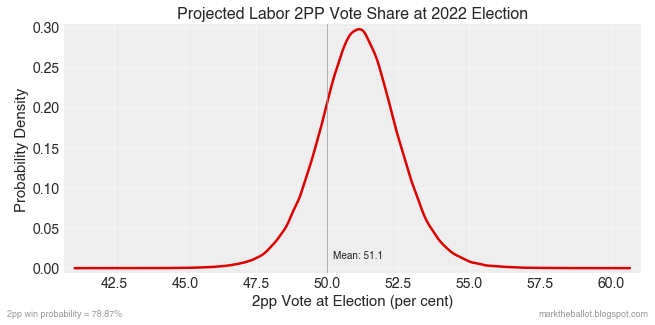

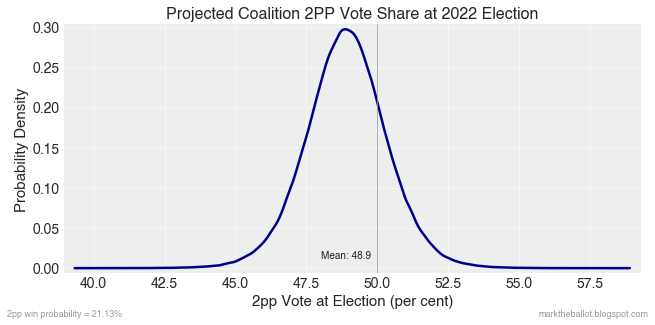

In [39]:
# Projected 2pp Vote at Election
plotables = {
    'Projected Labor 2PP Vote Share at 2022 Election': ['vote_2pp_L_predicted', COLOR_LABOR],
    'Projected Coalition 2PP Vote Share at 2022 Election': ['vote_2pp_C_predicted', COLOR_COALITION]
}

for heading, (data_item, color) in plotables.items():
    tpp_projected = get_var_as_series(trace, data_item)
    mean = tpp_projected.mean()
    kde = sm.nonparametric.KDEUnivariate(tpp_projected)
    fit = kde.fit(fft=True)
    series = pd.Series(fit.density, index=fit.support)
    win_probability = series[series.index > 50.0].sum() / series.sum() * 100
   
    fig, ax = common.initiate_plot()
    ax.plot(series, c=color, lw=2.5)
    ax.axvline(50, lw=0.75, c='#999999')
    ax.text(mean, 0.01, f'Mean: {mean:0.1f}', ha='center', va='bottom')
    
    common.plot_finalise(ax, title=heading, 
                         xlabel='2pp Vote at Election (per cent)', 
                         ylabel='Probability Density',
                         lfooter=f'2pp win probability = {win_probability:0.2f}%',
                        )

#### Number of seats won by party

__Note__: We plot this both as a probability mass function (PMF) and as a probability. The PMF gives the clearest indication of the most likely outcome. 

In [40]:
# We will reject samples with less than 0 other seats
# This is a bit of a kludge - borne of necessity - 
# because we don't have a compelling other parties model

others = get_var_as_series(trace, 'seats_other_count')
keep_mask = others > 0
rejected = (~keep_mask).sum()
kept = keep_mask.sum()
print(f'Number of samples rejected: {rejected} ({rejected/len(others)*100:0.2f}%)')
print(f'Number of samples kept: {kept}')

Number of samples rejected: 3649 (0.73%)
Number of samples kept: 496351


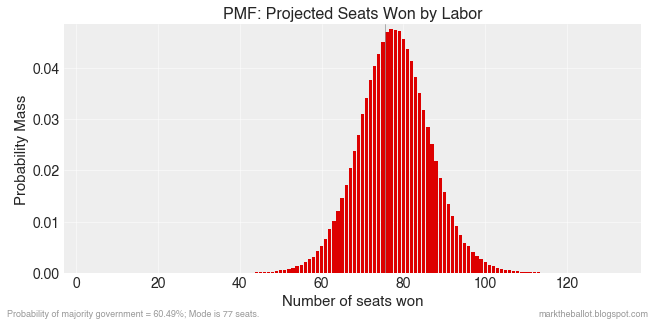

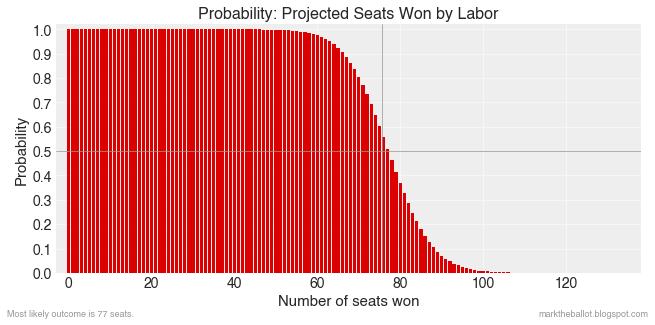

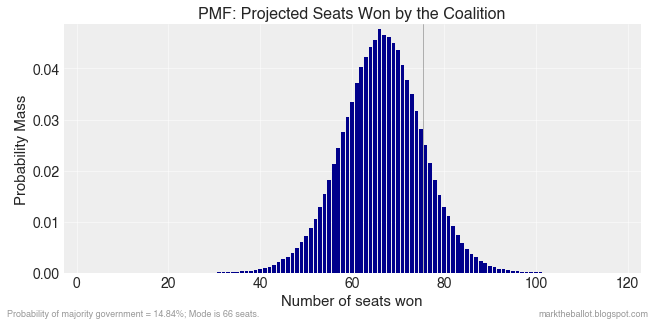

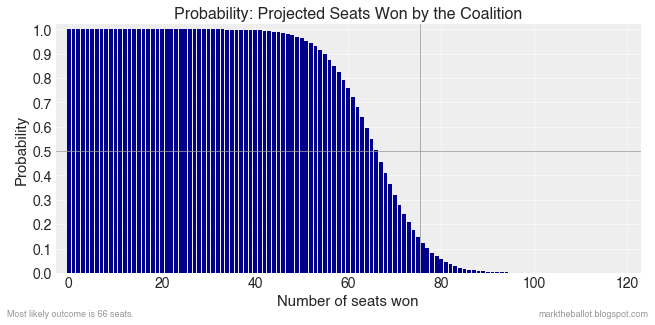

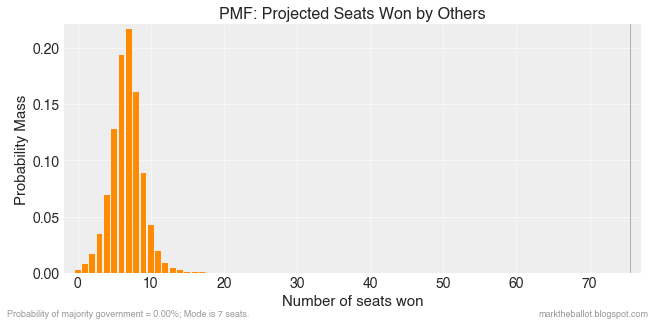

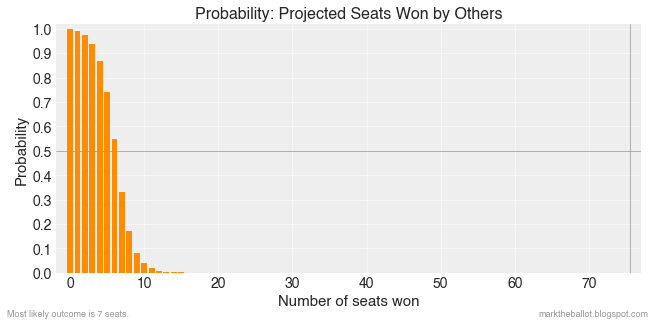

In [41]:
plotable = {
    'Projected Seats Won by Labor': ['final_labor_seats', COLOR_LABOR],
    'Projected Seats Won by the Coalition': ['final_coalition_seats', COLOR_COALITION],
    'Projected Seats Won by Others': ['seats_other_count', COLOR_OTHER],
}

majority = SEATS_IN_HOUSE/2.0
for title, (data_item, color) in plotable.items():
    seats = get_var_as_series(trace, data_item)[keep_mask]
    binned = seats.round(0).value_counts().sort_index()
    binned.index = binned.index.astype(int)
    binned = binned.reindex(range(binned.index.max()+1), fill_value=0)
    normalised = binned / binned.sum()
    probability = normalised[normalised.index > majority].sum() * 100
    mode = int(normalised.idxmax())

    # Probability Mass Function
    fig, ax = common.initiate_plot()
    ax.bar(normalised.index, normalised, color=color)
    ax.axvline(majority, lw=0.75, c='#999999')
    common.plot_finalise(
        ax, 
        title=f'PMF: {title}', 
        xlabel='Number of seats won',
        ylabel='Probability Mass',
        lfooter='Probability of majority government = '
                f'{probability:0.2f}%; Mode is {mode} seats.',
    )
    
    # As a probability - easier to conceptualise, 
    # harder to see most likely outcome
    cmf = 1 - normalised.cumsum()
    closest = (cmf - 0.5).abs().sort_values(ascending=True).index[0] # not used
    fig, ax = common.initiate_plot()
    ax.yaxis.set_major_locator(MaxNLocator(11))
    ax.bar(cmf.index, cmf, color=color)
    ax.axvline(majority, lw=0.75, c='#999999')
    ax.axhline(0.5, lw=0.75, c='#999999')
    common.plot_finalise(
        ax, 
        title=f'Probability: {title}', 
        xlabel='Number of seats won',
        ylabel='Probability',
        lfooter=f'Most likely outcome is {mode} seats.'
    )


#### Parliamentary outcomes

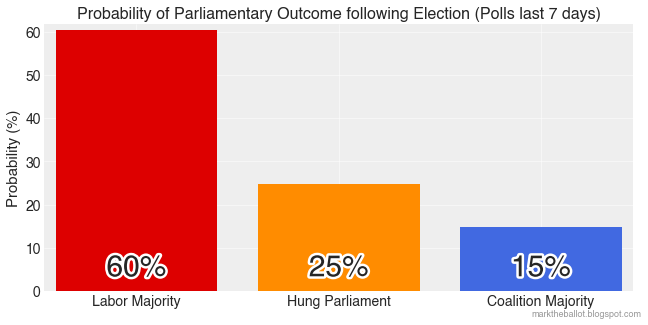

In [42]:
getable = {
    'Labor Majority': 'final_labor_seats',
    'Coalition Majority': 'final_coalition_seats',
}

results = {}
for label, data_item in getable.items():
    seats = get_var_as_series(trace, data_item)[keep_mask]
    results[label] =  (seats > majority).sum() / seats.count()
results['Hung Parliament'] = 1.0 - results['Labor Majority'] - results['Coalition Majority']
results = (pd.Series(results) * 100).sort_values(ascending=False) # per cent

colors = {
    'Labor Majority': COLOR_LABOR,
    'Coalition Majority': 'royalblue',
    'Hung Parliament': COLOR_OTHER,
}

fig, ax = common.initiate_plot()
for index, value in results.iteritems():
    ax.bar(index, value, color=colors[index])
    text = ax.text(index, 2, f'{value:0.0f}%', ha='center', va='bottom',
            fontsize=30)
    text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])

common.plot_finalise(ax, title='Probability of Parliamentary Outcome following Election '
                               f'(Polls last {FINAL_POLLING_PERIOD} days)',
                         xlabel=None, 
                         ylabel='Probability (%)',
                        )

In [43]:
results

Labor Majority        60.488042
Hung Parliament       24.674676
Coalition Majority    14.837282
dtype: float64

## The End

In [44]:
print('Done')

Done
